# Setting Limits for Real and Hypothetical Dielectric Stack Experiments

## 1: Imports 

In [2]:
# local pacakges
import boost
import statistical_methods as statistics

# utilities
import sys,getopt
from datetime import datetime
import itertools  

# numerical computing
import numpy as np
import pandas as pd
import math
from scipy import integrate
from scipy import stats as sps
from scipy import optimize as opt
import scipy.constants as const
from scipy.interpolate import interp1d
from scipy.optimize import brentq

# plotting
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

## 2: Setting Desired Parameters and Measurement Values

### 2.1: Stack Parameters

In [3]:
##When true, we will use a txt file of stack thicknesses, when false we will compute an unchirped stack
##Overruled if filed_boost==True
filed_stack=True # Default=True for measured stack

##file containing list of dielectric layer thicknesses(not air or mirror). Unused if filed_stack==False
stack_file="measured-thickness-080821.txt" # Default = "measured-thickness-080821.txt"

##When true, we will use a txt file of boost factors, when false we will compute from the stack.
filed_boost=False # Default=False, will compute boost factor from measured stack thicknesses

##file containing list of boost factors Unused if filed_boost==False
boost_file="boost-err-15per.npy" # Default ="boost-err-85per.npy", 15 with 85 for 85th percentile instead of 15th

##Indices of refraction 
n1,n2 = 1.4656, 2.0218 # Default=1.4656,2.0218 for SiO2, Si3N4

##Target wavelength. Wavelength used for computing stack dimensions. Unused if filed_stack==True [Unit: m]
wave_target=805e-9  # Default=805e-9 (805nm)

##Number of dielectric bilayers. Does not include air or mirror layer. Unused if filed_stack==True
N_bilayers=23  # Default=23 

##Is the stack mirrored True if it is, False if it is not.
mirror=True # Default = True

##Area of the stack [Unit: m^2]
AREA=np.pi*(0.025)**2 # Default=np.pi*(0.025)**2 for a 5cm diameter stack 



### 2.2: Sensor and Efficiency Parameters

In [4]:
##Which sensor will be used, "Excelitas" uses QE spectra from files, 
##"TES" uses a flat spectrum with a specified efficiency
sensor="Excelitas" #Default="Excelitas", options are "Excelitas", "TES", and "Custom"

##Specifies the filename of a custom made sensor PDE
customPDE="excelitas_PDE1Ve.csv"

##Flat efficiency of transition edge sensor. Unused if sensor!="TES". [Unit: %]
eta_TES=50

##optical/geometric photodetection efficiency of the system computed from GEANT4 simulation.
eta_photo=0.718 # Default = 0.718 

### 2.3: Measurement Values

In [5]:
##Time of the on and off measurements. [Unit: days]
days_on,days_off =  2/24, 0.5/24 #Defaults= 2/24, 0.5/24 for 2-hour on and 30-minute off measurements

##Measured count rate of the on and off measurements. Unused if n_on and n_off entered directly [Unit: Hz]
r_on,r_off = 98.6, 96.5 #Defaults= 98.6, 96.5 for Mudhi measurements

##Total measured number of counts from the on and off measurements. [Unit: counts]
n_on,n_off = r_on*days_on*24*60*60, r_off*days_off*24*60*60 #Defaults=r_on*days_on*24*60*60, r_off*days_off*24*60*60


### 2.4: Statistical Parameters

In [6]:
## Choice of statistical method to be applied.
##"A1" gives poisson statistics projected 90% exclusion limits assuming that r_on=r_off (useful check but not final)
##"A2" gives poisson statistics projected discovery power (useful check but not final)
##"B1" gives log-likelihood 90% exclusion limits (use for final exclusions)
##"B2" gives log-likelihood discovery power (use for final discovery power plots)
stat_choice="B1" #Default="B1" which should be used for anything serious

### 2.5: Dark Matter Parameters and Axion B Field

In [7]:
## Dark matter density parameter [Unit: GeV]
rho_dm = 0.3 #Default = 0.3, but common alternatives are 0.4 and 0.45

## Whether we will look for dark photons or axions. Dark photons if False, axions if True
axions=False #Default = False we are generally looking for dark photons

## Magnetic field used to convert to an axion search. Unused if axions==False. [Units: Tesla]
b_field=12 #Default = 12

##Dark matter fudge factor
fDM=1

## 3: Computing or Selecting Boost Factors and Detector Efficiencies

### 3.1: Create or Load a List of Stack Thicknesses and Compute the Boost Factors

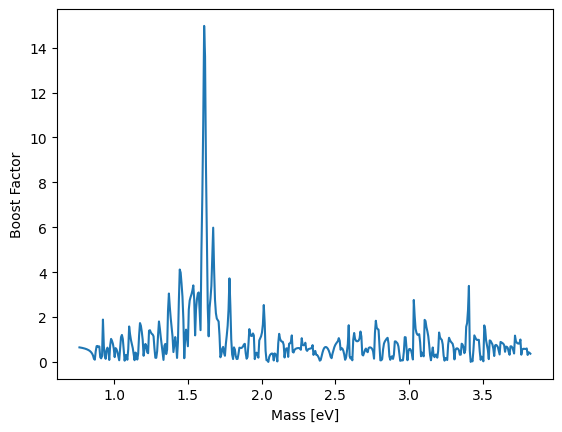

In [12]:
d1=wave_target/(2*n1) #thickness of the d1 layers [units: m]
#d1=2.736840000000001e-07 ##m

N_layers=N_bilayers*2+2 #number of bilayers times two plus a layer of air or mirror on either side
if(filed_boost):
    wave,boost_factor=np.load(boost_file)
else:
    if(filed_stack):
        dielectriclayers=np.loadtxt(stack_file,skiprows=1)[:,0]*1e-9 ## measured thicknesses
        w,boost_factor=boost.solution_rightwave(n1,n2,d1,len(dielectriclayers)+2,isTList=dielectriclayers,mirror=mirror)
    else:
        w,boost_factor=boost.solution_rightwave(n1,n2,d1,N_layers,mirror=mirror)
    wave = boost.freq_to_lamda(w)


mass=const.h*const.c/(wave*1e-9)*6.2*1e18



plt.plot(mass[::2],boost_factor[::2])
plt.ylabel("Boost Factor")
plt.xlabel("Mass [eV]");


### 3.2: Create or Load the QE Spectrum for the Chosen Sensor

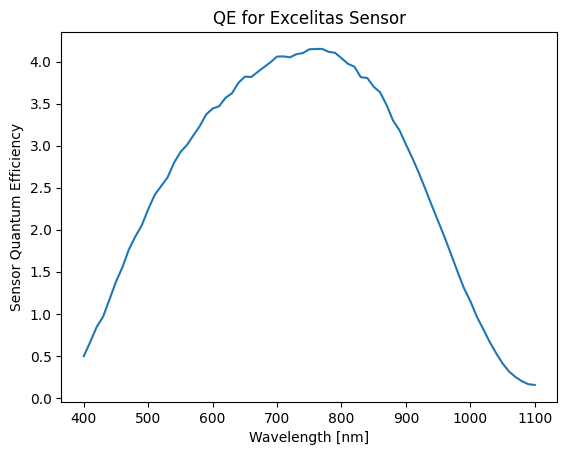

In [17]:
if sensor == "Excelitas":
    extractedData=pd.read_csv("excelitas_PDE1Ve.csv",names=["x","y"])
    qeX=extractedData.x.values
    qeY=extractedData.y.values*100
elif sensor == "TES":
    qeX=np.arange(410,1100,10)
    qeY=np.ones(len(qeX))*50
elif sensor == "Custom":
    extractedData=pd.read_csv(customPDE,names=["x","y"])
    qeX=extractedData.x.values
    qeY=extractedData.y.values*100
plt.plot(qeX,qeY)
plt.title("QE for " +sensor+ " Sensor")
plt.ylabel("Sensor Quantum Efficiency")
plt.xlabel("Wavelength [nm]");


### 3.3: Get Wavelengths to match between QE and Beta

In [18]:
mask = (wave<max(qeX)) & (wave>min(qeX)) 
wave = wave[mask]
boost_factor = boost_factor[mask]

In [19]:
qe_func = interp1d(qeX,qeY)
qeY = qe_func(wave)

## 4: Calling Statistical Methods to Compute Excluded Number of Counts

In [21]:
###Allows the use of a variety of statistical method to compute "N Star". For exclusion limits, this is the 
##Number of counts excluded during the on experiment, basically the excluded signal rate times the on time
##For discovery power, this is the discovered rate times the on time.

beta = 0.2

if (stat_choice=="A1"):
    n_star = (statistics.poisson_1sided_interval(n_off,beta)-np.round(n_off))*(days_on/days_off)
if (stat_choice=="A2"):
    sigmaDiscovery = 5
    n_star = statistics.disc_powerA(r_off,sigmaDiscovery)
if (stat_choice=="B1"):
    n_star = statistics.upper_limitB(n_on,n_off,days_on,days_off)
if (stat_choice=="B2"):
    n_star = statistics.discovery_powerB(r_off,days=days_on)
    



non0, noff0: 709920.0 173700.0
non, noff: 709920.0 173700.0
the signal at which the median no-signal dataset is excluded at 90% confidence is 17512.20257772278


## 5: Setting Limits on Dark Matter Coupling

In [22]:
mass=const.h*const.c/(wave*1e-9)*6.2*1e18
eta= qe_func(wave)*eta_photo/100 ## dividing by 100 since QE is expressed in %
coupling_squared=[]
for i, m in enumerate(mass):
    coupling_squared.append((n_star/(AREA*days_on))/( 5.2* (boost_factor[i]**2)* eta[i] * 1e27 * fDM)*(1/mass[i]))
    coupling=np.sqrt(coupling_squared)

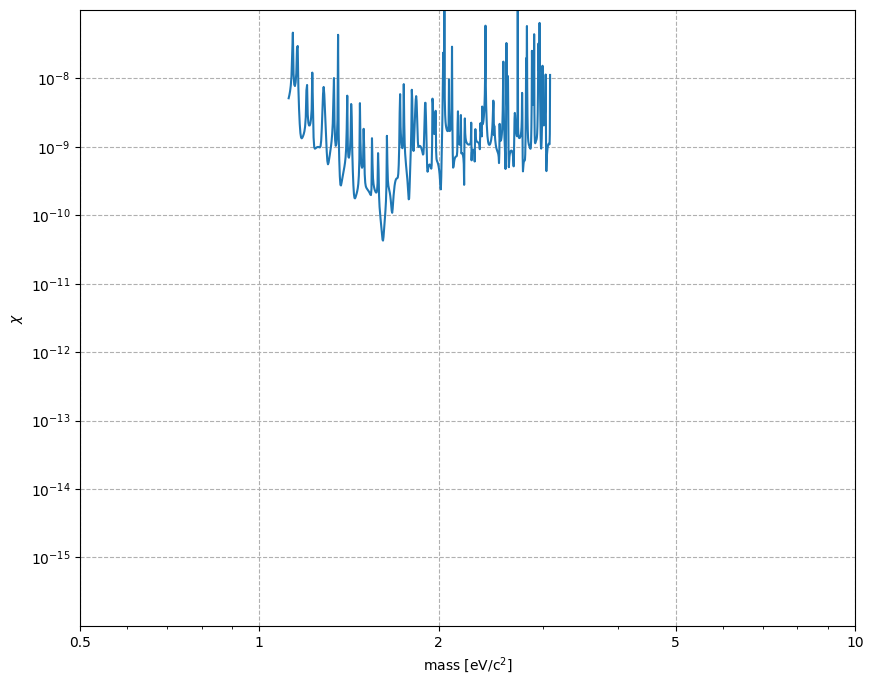

In [27]:
formatter = FuncFormatter(lambda y, _: '{:.3g}'.format(y))

fig,ax = plt.subplots(figsize=(10,8)) # set up the figure
skip=1

ax.plot(mass[::skip],coupling[::skip])

#--- plot formatting
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlim(0.5,10)
ax.set_ylim(1e-16,1e-7)
ax.set_xticks([0.5,1.0,2.0,5.0,10])
ax.set_yticks([1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8])

ax.xaxis.set_major_formatter(formatter)

plt.xlabel("mass [eV/c$^2$]")
plt.ylabel("$\chi$")
plt.grid(linestyle="--")

## 6: Plotting Limits Against Comparable Experiments

In [28]:
nowtime = datetime.now()
dt_string = nowtime.strftime("%Y%m%d%H%M%S")
bgd=n_off/(days_off*24*60*60)

if(~axions):
    ##Save a copy with the date attached
    np.save("./plot-data/"+dt_string+"B"+str(bgd)+stat_choice+"T"+str(np.round(days_on,2))+sensor+"Per"+str(100),coupling)
    np.save("./plot-data/"+dt_string+"B"+str(bgd)+stat_choice+"T"+str(np.round(days_on,2))+sensor+"Per"+str(100)+"-energy",mass)
    ##Overwrite the default copy
    #np.save("./plot-data/"+"1-15-LatestValue",coupling)
    #np.save("./plot-data/"+"1-15-LatestValue-energy",mass)   
    